In [1]:
import os
import logging


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.modeling.model_interactions import cities_model_interactions as model
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference,  train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root


In [2]:


# def aprep_data_for_interaction_inference(
#     outcome_dataset, intervention_dataset, intervention_variable, forward_shift
# ):
    
#     if torch.cuda.is_available():
#         device = torch.device("cuda")
#     else:
#         device = torch.device("cpu")

#     dg = DataGrabber()

#     tensed_covariates_datasets = [
#         var
#         for var in list_tensed_features()
#         if var not in [outcome_dataset, intervention_dataset]
#     ]
#     fixed_covariates_datasets = [
#         var
#         for var in list_available_features()
#         if var
#         not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]
#     ]

#     # TODO revise once transformations are available
#     dg.get_features_std_long(list_available_features())
#     dg.get_features_std_wide(list_available_features())

#     year_min = max(
#         dg.std_long[intervention_dataset]["Year"].min(),
#         dg.std_long[outcome_dataset]["Year"].min(),
#     )
#     year_max = min(
#         dg.std_long[intervention_dataset]["Year"].max(),
#         dg.std_long[outcome_dataset]["Year"].max(),
#     )
#     outcome_df = dg.std_long[outcome_dataset].sort_values(by=["GeoFIPS", "Year"])

#     # now we are adding forward shift to the outcome
#     # cleaning up and puting intervention/outcome in one df
#     # and fixed covariates in another

#     outcome_df[f"{outcome_dataset}_shifted_by_{forward_shift}"] = None

#     geo_subsets = []
#     for geo_fips in outcome_df["GeoFIPS"].unique():
#         geo_subset = outcome_df[outcome_df["GeoFIPS"] == geo_fips].copy()
#         # Shift the 'Value' column `forward_shift` in a new column
#         geo_subset[f"{outcome_dataset}_shifted_by_{forward_shift}"] = geo_subset[
#             "Value"
#         ].shift(-forward_shift)
#         geo_subsets.append(geo_subset)

#     outcome_df = pd.concat(geo_subsets).reset_index(drop=True)

#     outcome = outcome_df[
#         (outcome_df["Year"] >= year_min)
#         & (outcome_df["Year"] <= year_max + forward_shift)
#     ]

    
#     intervention = dg.std_long[intervention_dataset][
#         (dg.std_long[intervention_dataset]["Year"] >= year_min)
#         & (dg.std_long[intervention_dataset]["Year"] <= year_max)
#     ]


    
#     f_covariates = {
#         dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets
#     }
#     f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
#     for dataset in f_covariates.keys():
#         if dataset != fixed_covariates_datasets[0]:
#             if "GeoName" in f_covariates[dataset].columns:
#                 f_covariates[dataset] = f_covariates[dataset].drop(columns=["GeoName"])
#             f_covariates_joint = f_covariates_joint.merge(
#                 f_covariates[dataset], on=["GeoFIPS"]
#             )

#     i_o_data = pd.merge(outcome, intervention, on=["GeoFIPS", "Year"])

#     if "GeoName_x" in i_o_data.columns:
#         i_o_data.rename(columns={"GeoName_x": "GeoName"}, inplace=True)
#         columns_to_drop = i_o_data.filter(regex=r"^GeoName_[a-zA-Z]$")
#         i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

#     i_o_data.rename(columns={"Value": outcome_dataset}, inplace=True)

#     i_o_data["state"] = [code // 1000 for code in i_o_data["GeoFIPS"]]

#     N_s = len(i_o_data["state"].unique())  # number of states
#     i_o_data.dropna(inplace=True)

#     i_o_data["unit_index"] = pd.factorize(i_o_data["GeoFIPS"].values)[0]
#     i_o_data["state_index"] = pd.factorize(i_o_data["state"].values)[0]
#     i_o_data["time_index"] = pd.factorize(i_o_data["Year"].values)[0]

#     assert i_o_data["GeoFIPS"].isin(f_covariates_joint["GeoFIPS"]).all()

#     print(outcome_dataset)
#     display(i_o_data.head())
#     print("null?", i_o_data.isnull().any())

#     y_for_tensor = i_o_data[["GeoFIPS", "Year", f"{outcome_dataset}_shifted_by_{forward_shift}"]].copy()

#     display(y_for_tensor.pivot(index='Year', columns='GeoFIPS', values='industry_transportation_warehousing_total_shifted_by_1').head())
#    y_for_tensor = y_for_tensor.pivot(index="Year", columns="GeoFIPS", values=f"{outcome_dataset}_shifted_by_{forward_shift}")
#    display(y_for_tensor.head())

    #print(y_for_tensor.shape)

    #y_reshaped =torch.Tensor(y_for_tensor.values, dtype= torch.float32, device=device)

    # f_covariates_joint.drop(columns=["GeoName"], inplace=True)
    # data = i_o_data.merge(f_covariates_joint, on="GeoFIPS", how="left")

    # # assert not data.isna().any().any()

    # time_index_idx = data.columns.get_loc("time_index")
    # covariates_df = data.iloc[:, time_index_idx + 1 :].copy()
    # covariates_df_sparse = covariates_df.copy()
    # covariates_df_sparse["unit_index"] = data["unit_index"]
    # covariates_df_sparse["state_index"] = data["state_index"]
    # covariates_df_sparse.drop_duplicates(inplace=True)
    # assert set(covariates_df_sparse["unit_index"]) == set(data["unit_index"])

    # # get tensors

    # if torch.cuda.is_available():
    #     device = torch.device("cuda")
    # else:
    #     device = torch.device("cpu")

    # y = data[f"{outcome_dataset}_shifted_by_{forward_shift}"]
    # y = torch.tensor(y, dtype=torch.float32, device=device)

    # unit_index = torch.tensor(data["unit_index"], dtype=torch.int, device=device)
    # unit_index_sparse = torch.tensor(
    #     covariates_df_sparse["unit_index"], dtype=torch.int
    # )

    # state_index = torch.tensor(data["state_index"], dtype=torch.int, device=device)
    # state_index_sparse = torch.tensor(
    #     covariates_df_sparse["state_index"], dtype=torch.int
    # )

    # time_index = torch.tensor(data["time_index"], dtype=torch.int, device=device)
    # intervention = torch.tensor(
    #     data[intervention_variable], dtype=torch.float32, device=device
    # )

    # covariates = torch.tensor(covariates_df.values, dtype=torch.float32, device=device)

    # covariates_df_sparse.drop(columns=["unit_index", "state_index"], inplace=True)
    # covariates_sparse = torch.tensor(
    #     covariates_df_sparse.values, dtype=torch.float32, device=device
    # )

    # N_cov = covariates.shape[1]  # number of covariates
    # N_u = covariates_sparse.shape[0]  # number of units (counties)
    # N_obs = len(y)  # number of observations
    # N_t = len(time_index.unique())  # number of time points
    # N_s = len(state_index.unique())  # number of states

    # assert len(intervention) == len(y)
    # assert len(unit_index) == len(y)
    # assert len(state_index) == len(unit_index)
    # assert len(time_index) == len(unit_index)
    # assert covariates.shape[1] == covariates_sparse.shape[1]
    # # assert len(unit_index_sparse) == N_u

    # return {
    #     "N_t": N_t,
    #     "N_cov": N_cov,
    #     "N_s": N_s,
    #     "N_u": N_u,
    #     "N_obs": N_obs,
    #     "unit_index": unit_index,
    #     "state_index": state_index,
    #     "time_index": time_index,
    #     "unit_index_sparse": unit_index_sparse,
    #     "state_index_sparse": state_index_sparse,
    #     "covariates": covariates,
    #     "covariates_sparse": covariates_sparse,
    #     "intervention": intervention,
    #     "y": y,
    # }

In [3]:
# outcome_dataset='industry_transportation_warehousing_total'
# intervention_dataset='spending_transportation'
# forward_shift = 3

# dg = DataGrabber()

# dg.get_features_std_long([intervention_dataset, outcome_dataset])

# intervention_variable = dg.std_long[intervention_dataset].columns[-1]

# loaded_data = {}
# loaded_data[forward_shift] =  prep_data_for_interaction_inference(
#         outcome_dataset=outcome_dataset,
# intervention_dataset=intervention_dataset,
# intervention_variable=intervention_variable,
# forward_shift=forward_shift, 
#     )



# model_args= (
#         loaded_data[forward_shift]['N_t'],
#         loaded_data[forward_shift]['N_cov'],
#         loaded_data[forward_shift]['N_s'],
#         loaded_data[forward_shift]['N_u'],
#         loaded_data[forward_shift]['N_obs'],
#         loaded_data[forward_shift]['state_index_sparse'],
#         loaded_data[forward_shift]['state_index'],
#         loaded_data[forward_shift]['time_index'],
#         loaded_data[forward_shift]['unit_index'],
#         loaded_data[forward_shift]['unit_index_sparse'],
#     )


In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


outcome_dataset='industry_transportation_warehousing_total'
intervention_dataset='spending_transportation'
forward_shift = 3


dg = DataGrabber()

dg.get_features_std_long([intervention_dataset, outcome_dataset])

intervention_variable = dg.std_long[intervention_dataset].columns[-1]

tensed_covariates_datasets = [
    var
    for var in list_tensed_features()
    if var not in [outcome_dataset, intervention_dataset]
]
fixed_covariates_datasets = [
    var
    for var in list_available_features()
    if var
    not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]
]

features_needed = [outcome_dataset, intervention_dataset] + fixed_covariates_datasets

#dg.get_features_std_long(features_needed)
dg.get_features_std_wide(features_needed)


intervention = dg.std_wide[intervention_dataset]
outcome = dg.std_wide[outcome_dataset]

year_min =  max(
intervention.columns[2:].astype(int).min(),
outcome.columns[2:].astype(int).min(),
)

year_max = min(
    intervention.columns[2:].astype(int).max(),
    outcome.columns[2:].astype(int).max(),
)

assert all(intervention['GeoFIPS'] == outcome['GeoFIPS'])

outcome_shifted = outcome.copy()
for year in range(year_min, year_max - forward_shift+ 1):
    outcome_shifted[f'{year}'] = outcome_shifted[f'{year + forward_shift}']

years_to_drop = [f"{year}" for year in range(year_max - forward_shift + 1, year_max + 1) ] 

outcome_shifted.drop(columns= years_to_drop, inplace=True)
intervention.drop(columns= years_to_drop, inplace=True)

assert outcome_shifted['GeoFIPS'].equals(intervention['GeoFIPS'])
assert outcome_shifted['GeoFIPS'].nunique() == len(outcome_shifted['GeoFIPS'])


f_covariates = {
    dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets
}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if "GeoName" in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=["GeoName"])
        f_covariates_joint = f_covariates_joint.merge(
            f_covariates[dataset], on=["GeoFIPS"]
        )

display(f_covariates_joint.head())


assert f_covariates_joint['GeoFIPS'].equals(intervention['GeoFIPS'])

unit_index = pd.factorize(f_covariates_joint['GeoFIPS'].values)[0]
state_index = pd.factorize(f_covariates_joint['GeoFIPS'].values // 1000)[0]



# prepare tensors

x = torch.tensor(f_covariates_joint.iloc[:, 2:].values, dtype=torch.float32, device=device)
x = x.unsqueeze(1).unsqueeze(1).permute(2,3, 1, 0)
print("xshape", x.shape)

t = torch.tensor(intervention.iloc[:, 2:].values, dtype=torch.int, device=device)
t = t.unsqueeze(1).unsqueeze(1).permute(3, 1, 2, 0)
print("tshape", t.shape)

y = torch.tensor(outcome_shifted.iloc[:, 2:].values, dtype=torch.float32, device=device)
y = y.unsqueeze(1).unsqueeze(1).permute(3, 1, 2, 0)
print("yshape", y.shape)

state_index = torch.tensor(state_index, dtype=torch.int, device=device)
unit_index = torch.tensor(unit_index, dtype=torch.int, device=device)






print(N_t,N_cov, N_s, N_u)

#model_args = (N_t, N_cov, N_s, N_u, state_index_sparse, unit_index_sparse, leeway=0.2)


,GeoFIPS,GeoName,mexican,puerto_rican,cuban,other_hispanic_latino,white,black_african_american,american_indian_alaska_native,asian,...,arts_entertainment,other_services,public_admin,roadDensity,WeightAvgNatWalkInd,POPDEN_RUR,POPDEN_URB,HOUDEN_COU,HOUDEN_RUR,ALAND_PCT_RUR
0,1001,"Autauga, AL",-0.075204,0.029844,0.030849,-0.071389,-0.019340,0.129096,-0.034591,-0.013974,...,0.085490,0.010974,0.187865,-0.050600,-0.086744,0.000723,0.034281,-0.013434,-0.007680,0.027263
1,1003,"Baldwin, AL",-0.061204,-0.017850,0.018239,-0.022864,0.058846,0.000697,-0.027936,-0.023214,...,0.110343,0.001422,-0.023318,-0.017362,0.031591,0.069828,-0.010826,-0.006553,0.092109,-0.027662
2,1005,"Barbour, AL",-0.046322,-0.037163,-0.036542,-0.056007,-0.249249,0.424910,-0.032133,-0.055586,...,0.007307,-0.094909,0.083378,-0.085048,-0.115609,-0.085861,0.015305,-0.018591,-0.091052,0.059419
3,1007,"Bibb, AL",-0.080816,0.047480,-0.013982,-0.058531,-0.011475,0.154438,-0.036215,-0.068459,...,-0.218289,0.252320,-0.016282,-0.054219,-0.108112,-0.021855,-0.095419,-0.018344,-0.035769,0.067134
4,1009,"Blount, AL",0.016903,-0.056081,-0.019027,-0.046799,0.086370,-0.086366,-0.035667,-0.058760,...,-0.163846,0.061867,-0.116476,0.004108,-0.157765,0.158224,0.007746,-0.013949,0.155545,0.059701


xshape torch.Size([1, 30, 1, 3074])
tshape torch.Size([9, 1, 1, 3074])
yshape torch.Size([9, 1, 1, 3074])
9 30 51 3074


In [7]:
def model_testing(
    N_t,
    N_cov,
    N_s,
    N_u,
    state_index,
    unit_index,
    leeway=0.2,
):
    bias_Y = pyro.sample("bias_Y", dist.Normal(0, leeway))
    bias_T = pyro.sample("bias_T", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))

    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))
 
    counties_plate = pyro.plate("counties_plate", N_u, dim=-1)
    states_plate = pyro.plate("states_plate", N_s, dim=-2)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-3)
    time_plate = pyro.plate("time_plate", N_t, dim=-4)

    with covariates_plate:
        bias_X = pyro.sample("bias_X", dist.Normal(0, leeway))
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1))
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway))
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway))

    with states_plate:
        bias_stateT = pyro.sample("bias_stateT", dist.Normal(0, leeway))
        bias_stateY = pyro.sample("bias_stateY", dist.Normal(0, leeway))

        with covariates_plate:
            bias_stateX = pyro.sample("bias_stateX", dist.Normal(0, leeway))

    with time_plate:
        bias_timeT = pyro.sample("bias_timeT", dist.Normal(0, leeway))
        bias_timeY = pyro.sample("bias_timeY", dist.Normal(0, leeway))

    with counties_plate:
        with covariates_plate:
        
            mean_X = pyro.deterministic("mean_X", torch.einsum("...xdd,...xcd->...xdc", bias_X, bias_stateX[...,state_index,:])) #.unsqueeze(-1))
            #print("xmeans inside", mean_X[...,unit_index_sparse].shape)
        #print("mean_X inside", mean_X.shape) 
            
            
            X = pyro.sample("X", dist.Normal(mean_X[...,unit_index], sigma_X)) # cudd
        
            XT_weighted =  torch.einsum("...xdc, ...xdd -> ...dc", X, weight_XT).unsqueeze(-2)
            XY_weighted =  torch.einsum("...xdc, ...xdd -> ...dc", X, weight_XY).unsqueeze(-2)
            print("XT_weighted", XT_weighted.shape)
        #      # dudd

        # print("bsT", bias_stateT.shape)
        # print("bsTindexed", bias_stateT[...,state_index_sparse,:].shape ) #[...,state_index_sparse,:].shape)
        # print("sanity", (bias_T + bias_timeT + bias_stateT[...,state_index_sparse,:]).shape)


        with time_plate:
            
            bias_stateT_tiled = pyro.deterministic("bias_stateT_tiled", torch.einsum("...cd -> ...dc", bias_stateT[...,state_index,:]))
            
            mean_T = pyro.deterministic("mean_T",  bias_T + bias_timeT + bias_stateT_tiled +  XT_weighted)

            T = pyro.sample("T", dist.Normal(mean_T, sigma_T))
            
            bias_stateY_tiled = pyro.deterministic("bias_stateY_tiled", torch.einsum("...cd -> ...dc", 
                                                                        bias_stateY[...,state_index,:]))
            # same dimension switchiing as for T_bias_with_state

            # #print("Y_bias_with_state", Y_bias_with_state.shape) 
            # Y_bias_with_time = pyro.deterministic("Y_bias_with_time", torch.einsum("...c, ...tddd -> tdc",
            #                                                 Y_bias_with_state, bias_timeY).unsqueeze(-2))
            
            # #print("wty", (weight_TY * T).shape)
            # Y_bias_with_tau = pyro.deterministic("Y_bias_with_tau",
            #                                       torch.einsum("...tcsu, ...tcsu -> tcsu", Y_bias_with_time, weight_TY * T))

            #print("linewise", XY_weighted[...,unit_index_sparse].shape)

            mean_Y = pyro.deterministic("mean_Y", 
                                        bias_Y + bias_timeY + bias_stateY_tiled + XY_weighted + weight_TY * T)
            
            # Y_with_state_bias_and_tau =  torch.einsum("...tddd, ...cd-> ...c", (bias_Y + bias_timeY), bias_stateY[...,state_index_sparse,:]) + weight_TY * T
            # #print("Y with state bias_and_tau", Y_with_state_bias_and_tau.shape)
            # mean_Y = pyro.deterministic("mean_Y", torch.einsum("...tddu, ...u -> tdu",
            #                             Y_with_state_bias_and_tau,
            #                           XY_weighted).unsqueeze(-2)
            #                           )
            
            # # #print("mean_Y", mean_Y.shape)
            Y = pyro.sample("Y", dist.Normal(mean_Y, sigma_Y))

    #             print(mean_T.shape)
    #             print(T.shape)
    # # with observations_plate:
    #     mean_T = 
    # (
    #         bias_T
    #         + weight_UtT[time_index]
    #         + weight_UsT[state_index]
    #         + XT_weighted[unit_index]
    #     )

    #     T = pyro.sample("T", dist.Normal(mean_T, sigma_T))

    #     mean_Y = (
    #         bias_Y
    #         + weight_UtY[time_index]
    #         + weight_UsY[state_index]
    #         + weight_TY * T
    #         + XY_weighted[unit_index]
    #     )

    #     Y = pyro.sample("Y", dist.Normal(mean_Y, sigma_Y))

    # return Y 

with pyro.poutine.trace() as tr:
    model_testing(*model_args)
  
for key in tr.trace.nodes.keys():
    if not key.endswith("plate"):
        print(key, tr.trace.nodes[key]["value"].shape)


pyro.render_model( 
            model_testing, model_args=model_args, render_distributions=True
        )

NameError: name 'model_args' is not defined

In [142]:
# X = loaded_data[forward_shift]['covariates_sparse']
# X_reshaped = X.unsqueeze(1).permute(2, 1, 0)
# print(X_reshaped.shape)

# #Y = loaded_data[forward_shift]['y']
#print(Y.shape)

torch.Size([30, 1, 3036])


In [143]:
# model =  pyro.condition(
#             model_testing,
#             data={#"T": loaded_data[forward_shift]['intervention'], "Y": loaded_data[forward_shift]['y'], 
#                   "X": X_reshaped},
#         )



XT_weighted torch.Size([1, 1, 3036])
XT_weighted torch.Size([1, 1, 3036])
[iteration 0001] loss: 179687.0058
XT_weighted torch.Size([1, 1, 3036])
[iteration 0002] loss: 188924.5482
XT_weighted torch.Size([1, 1, 3036])
[iteration 0003] loss: 179225.9722
XT_weighted torch.Size([1, 1, 3036])
[iteration 0004] loss: 174034.1494
XT_weighted torch.Size([1, 1, 3036])
[iteration 0005] loss: 176269.3503
XT_weighted torch.Size([1, 1, 3036])
[iteration 0006] loss: 178720.6300
XT_weighted torch.Size([1, 1, 3036])
[iteration 0007] loss: 177091.9748
XT_weighted torch.Size([1, 1, 3036])
[iteration 0008] loss: 171363.5008
XT_weighted torch.Size([1, 1, 3036])
[iteration 0009] loss: 172671.5032
XT_weighted torch.Size([1, 1, 3036])
[iteration 0010] loss: 169042.4721
XT_weighted torch.Size([1, 1, 3036])
[iteration 0011] loss: 162914.9014
XT_weighted torch.Size([1, 1, 3036])
[iteration 0012] loss: 158002.5091
XT_weighted torch.Size([1, 1, 3036])
[iteration 0013] loss: 154383.3033
XT_weighted torch.Size([1, 

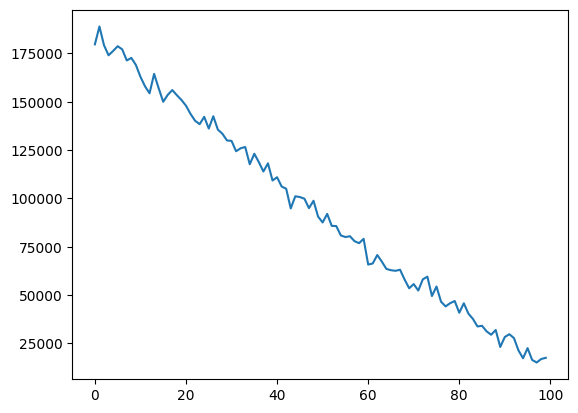

In [144]:
pyro.clear_param_store()
num_iterations = 100
plot_loss = True
print_interval = True
lr = 0.01


guide = AutoNormal(model)

svi = SVI(model=model, guide=guide, optim=Adam({"lr": lr}), loss=Trace_ELBO())

losses = []
for step in range(num_iterations):
    loss = svi.step(*model_args)
    losses.append(loss)
    if step % print_interval == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss))


plt.plot(range(num_iterations), losses, label="Loss")
plt.show()


In [145]:
predictive = Predictive(model, guide=guide, num_samples=500, parallel=False)
samples = predictive(*model_args)


XT_weighted torch.Size([1, 1, 3036])
XT_weighted torch.Size([1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_weighted torch.Size([1, 1, 1, 3036])
XT_wei